In [ ]:
pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade tensorflow tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
      Successfully uninstalled tensorflow-2.11.0


In [ ]:
import time
start_time=time.time()

Import necessary libraries


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import LazyAdam
from keras.layers import Dropout

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)


from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

LOAD DATA


In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# create new column weekday
train['weekday'] = np.where(train['date'].dt.dayofweek < 5, 0, 1)
test['weekday'] = np.where(test['date'].dt.dayofweek < 5, 0, 1)
# perform one-hot encoding
train = pd.get_dummies(train, columns=['weekday'])
test = pd.get_dummies(test, columns=['weekday'])

#fill sales data with 0 in test set
test['sales'] = 0

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert the 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

# Create weekday and weekend indicator variables based on the 'date' column
train['weekday_weekend'] = np.where(train['date'].dt.weekday < 5, 'weekday', 'weekend')

# Select columns to be scaled
val_cols = ['store', 'item']
num_cols = ['sales']

# Scale the numerical columns using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 200))
train[num_cols] = scaler.fit_transform(train[num_cols])

# Add the 'date', 'store', and 'item' columns back to the dataset
train = train[['date'] + val_cols + num_cols + ['weekday_weekend']]

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#Convert the 'date' column to datetime format
test['date'] = pd.to_datetime(test['date'])

#Create weekday and weekend indicator variables based on the 'date' column
test['weekday_weekend'] = np.where(test['date'].dt.weekday < 5, 'weekday', 'weekend')

#Scale the numerical columns using MinMaxScaler

val_cols = ['store', 'item']
num_cols = ['sales']
scaler = MinMaxScaler(feature_range=(0, 200))
test[num_cols] = scaler.fit_transform(test[num_cols])

#Add the 'date' column back to the dataset
test = test[['date'] +val_cols+ num_cols + ['weekday_weekend']]

Trainset data description


In [ ]:
train.describe()

,store,item,sales
count,54913.000000,54912.000000,54912.000000
mean,5.489101,2.004808,51.016049
std,2.877342,0.821382,28.249904
min,1.000000,1.000000,0.000000
25%,3.000000,1.000000,29.530201
50%,5.000000,2.000000,44.295302
75%,8.000000,3.000000,67.114094
max,10.000000,4.000000,200.000000


In [ ]:
train.head()

,date,store,item,sales,weekday_weekend
0,2013-01-01,1,1.0,16.107383,weekday
1,2013-02-01,1,1.0,13.422819,weekday
2,2013-03-01,1,1.0,17.449664,weekday
3,2013-04-01,1,1.0,16.107383,weekday
4,2013-05-01,1,1.0,12.080537,weekday


In [ ]:
import pandas as pd

# load train and test DataFrames
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# sort the 'date' column in each DataFrame in descending order
train = train.sort_values('date', ascending=True)
test = test.sort_values('date', ascending=True)

# extract the latest date from each DataFrame
train_last_date = train.iloc[-1]['date']
test_last_date = test.iloc[-1]['date']

# convert latest dates to datetime objects and format them as strings
train_last_date = pd.to_datetime(train_last_date).strftime('%Y-%m-%d')
test_last_date = pd.to_datetime(test_last_date).strftime('%Y-%m-%d')


In [ ]:
# Print minimum and maximum date of train set
print("Train set date range: {} to {}".format(train['date'].min(), train['date'].max()))

# Print minimum and maximum date of test set
print("Test set date range: {} to {}".format(test['date'].min(), test['date'].max()))


Train set date range: 01-01-2013 to 31-12-2017
Test set date range: 01-01-2018 to 31-03-2018


In [ ]:
# print the latest dates and the number of days between them
print("Train last date:", train_last_date)
print("Test last date:", test_last_date)
lag_size = (pd.to_datetime(test_last_date) - pd.to_datetime(train_last_date)).days
print("Number of days between train and test last dates:", lag_size)


Train last date: 2017-12-31
Test last date: 2018-03-31
Number of days between train and test last dates: 90


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:

daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
fig = go.Figure(data=[daily_sales_sc],layout=layout)
fig.show(renderer="colab")


In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

Reduce training set with the last year alone

In [ ]:
train = train[(train['date'] >= '2017-01-01')]

Rearrange datsets to apply shift methods


In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1.0,1,21-01-2013,8.0
1,1.0,1,21-01-2014,7.0
2,1.0,1,21-01-2015,10.0
3,1.0,1,21-01-2016,12.0
4,1.0,1,21-01-2017,13.0


conversion of data into timeseries

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


forecast 90 days with current timesteps


In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,8.0,1.0,1.0,7.0,1.0,1.0,10.0,1.0,...,34.0,1.0,1.0,25.0,1.0,1,26.0,1.0,1.0,6.0
30,1.0,1.0,7.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,25.0,1.0,1.0,26.0,1.0,1,26.0,1.0,1.0,9.0
31,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,13.0,1.0,...,26.0,1.0,1.0,26.0,1.0,1,21.0,1.0,1.0,18.0
32,1.0,1.0,12.0,1.0,1.0,13.0,1.0,1.0,13.0,1.0,...,26.0,1.0,1.0,21.0,1.0,1,29.0,1.0,1.0,14.0
33,1.0,1.0,13.0,1.0,1.0,13.0,1.0,1.0,16.0,1.0,...,21.0,1.0,1.0,29.0,1.0,1,34.0,1.0,1.0,23.0


drop items other than the shifted

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

Remove unwanted columns


In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

train validation split

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10716, 30)
Validation set shape (7144, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
3617,22.0,14.0,13.0,14.0,13.0,12.0,25.0,13.0,17.0,15.0,...,12.0,8.0,6.0,7.0,6.0,17.0,25.0,8.0,11.0,20.0
7582,84.0,54.0,70.0,100.0,38.0,68.0,68.0,79.0,79.0,67.0,...,35.0,48.0,54.0,52.0,48.0,48.0,56.0,50.0,53.0,64.0
897,26.0,19.0,11.0,17.0,23.0,23.0,20.0,29.0,17.0,27.0,...,25.0,37.0,41.0,32.0,30.0,33.0,58.0,43.0,33.0,45.0
5845,23.0,22.0,12.0,30.0,18.0,15.0,10.0,31.0,18.0,13.0,...,28.0,31.0,35.0,20.0,21.0,31.0,31.0,38.0,22.0,20.0
10825,115.0,75.0,75.0,100.0,70.0,78.0,51.0,78.0,67.0,86.0,...,72.0,38.0,56.0,38.0,64.0,72.0,40.0,42.0,54.0,66.0


In [ ]:
from keras import optimizers
epochs = 100
batch = 96
lr = 0.001

for cnn parameters(samples,timesteps,features)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10716, 30, 1)
Validation set shape (7144, 30, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Reshape, TimeDistributed
from keras import optimizers


model_cnn = Sequential()
model_cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(1))


from tensorflow_addons.optimizers import LazyAdam
opt = LazyAdam(lr)
model_cnn.compile(loss='mse', optimizer=opt)
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 29, 256)           768       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 14, 256)          0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 3584)              0         
                                                                 
 dense_12 (Dense)            (None, 50)                179250    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                     




Lstm

In [ ]:

model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))

from tensorflow_addons.optimizers import LazyAdam
opt = LazyAdam(lr)
model_cnn.compile(loss='mse', optimizer=opt)
model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


CNN-LSTM [sample,subsequences,timesteps,features]

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10716, 2, 15, 1)
Validation set shape (7144, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')
model_cnn_lstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
335/335 - 6s - loss: 178.1123 - val_loss: 163.9176 - 6s/epoch - 19ms/step
Epoch 2/100
335/335 - 4s - loss: 160.5930 - val_loss: 175.5550 - 4s/epoch - 11ms/step
Epoch 3/100
335/335 - 6s - loss: 159.2643 - val_loss: 158.2858 - 6s/epoch - 17ms/step
Epoch 4/100
335/335 - 4s - loss: 156.5166 - val_loss: 161.9154 - 4s/epoch - 13ms/step
Epoch 5/100
335/335 - 4s - loss: 157.0008 - val_loss: 156.4359 - 4s/epoch - 11ms/step
Epoch 6/100
335/335 - 4s - loss: 156.9371 - val_loss: 158.3882 - 4s/epoch - 13ms/step
Epoch 7/100
335/335 - 6s - loss: 155.4548 - val_loss: 156.7883 - 6s/epoch - 18ms/step
Epoch 8/100
335/335 - 4s - loss: 154.0630 - val_loss: 157.9311 - 4s/epoch - 12ms/step
Epoch 9/100
335/335 - 4s - loss: 153.9579 - val_loss: 158.5233 - 4s/epoch - 13ms/step
Epoch 10/100
335/335 - 6s - loss: 153.0374 - val_loss: 156.0332 - 6s/epoch - 17ms/step
Epoch 11/100
335/335 - 5s - loss: 154.0774 - val_loss: 156.4204 - 5s/epoch - 14ms/step
Epoch 12/100
335/335 - 4s - loss: 155.7109 - val_los

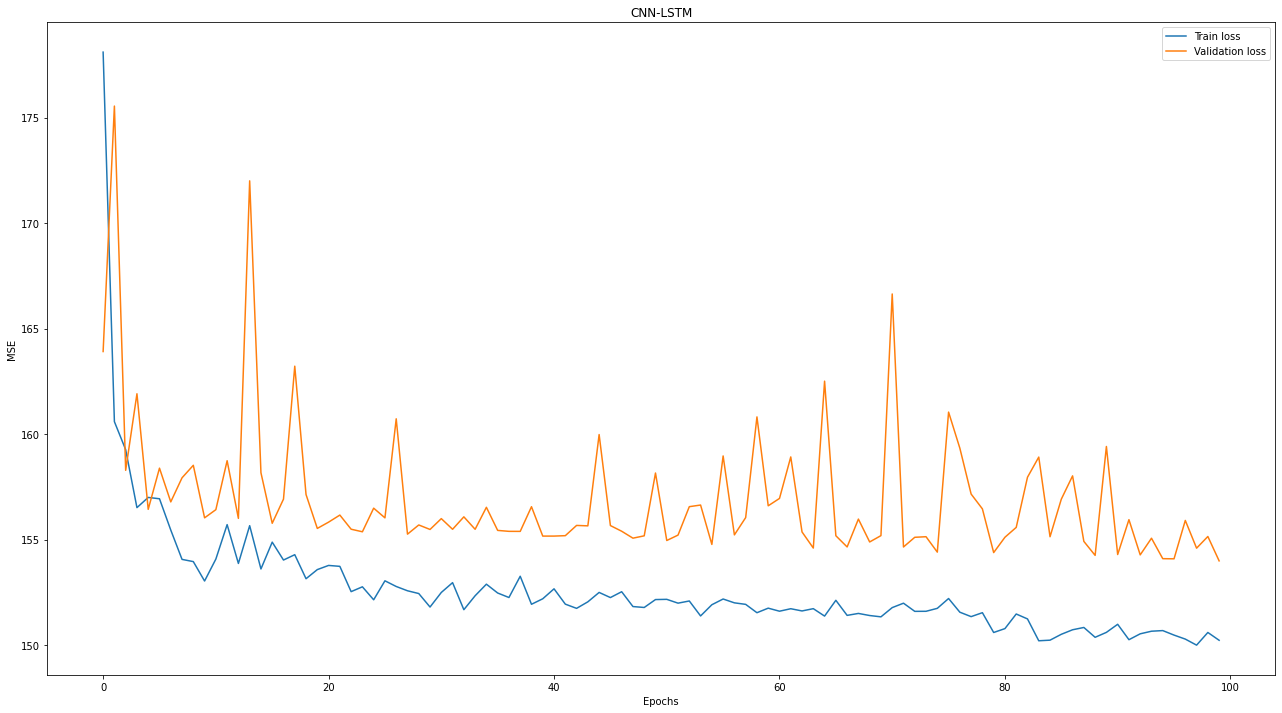

In [ ]:
fig, ax4 = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(22,12))

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

Calculating RMSE

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print("Shape of array: ", cnn_lstm_valid_pred .shape)
print("Shape of array: ", Y_valid.shape)
end_time=time.time()
import numpy as np

# Define bins
bins = np.linspace(0, 200, num=201)

# Convert continuous predictions to discrete values
cnn_lstm_valid_pred_discrete = np.digitize(cnn_lstm_valid_pred, bins) - 1
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
# Calculate metrics
y_val_classes = Y_valid.reshape(Y_valid.shape[0],1)
print("Shape of array: ", y_val_classes.shape)
accuracy = accuracy_score(y_val_classes,cnn_lstm_valid_pred_discrete)
precision = precision_score(y_val_classes, cnn_lstm_valid_pred_discrete, average='weighted')
recall = recall_score(y_val_classes, cnn_lstm_valid_pred_discrete, average='weighted')
f1 = f1_score(y_val_classes, cnn_lstm_valid_pred_discrete, average='weighted')

print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

224/224 [==============================] - 2s 7ms/step
Shape of array:  (7144, 1)
Shape of array:  (7144,)
Shape of array:  (7144, 1)
Accuracy: 4.45%
Precision: 4.60%
Recall: 4.45%
F1 Score: 4.31%
Train rmse: 12.198544592221765
Validation rmse: 12.40939374983454


Calculating Performance measures

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(Y_train, cnn_lstm_train_pred)
mape = mean_absolute_percentage_error(Y_train, cnn_lstm_train_pred) * 100
r2 = r2_score(Y_train, cnn_lstm_train_pred)
execution_time=end_time-start_time


# Print the results
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.2f}%".format(mape))
print("R-squared: {:.4f}".format(r2))
print("Execution time",execution_time)